## MMTHE01 - Masters Thesis

### E1. Thesis - Apply and Evaluate different XAI methods - Case Study with XGBoost Model
* Applying XAI on a Supervised Learning AI model (XGBoost with SMOTE)
* Applying Model Agnostic Perturbation-based global XAI methods: SP-LIME, NormLIME, Permutation Importance, Adversarial Explanations

#### Importing the libraries

In [1]:
### import general libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import time
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder

In [2]:
# Check your current working directory
cwd = os.getcwd()

# Define your relative path
relative_path = r"6. Analysis"  # adjust this relative to cwd

# Build the full path
full_path = os.path.join(cwd, relative_path)

# Check if it exists before changing
if os.path.exists(full_path):
    os.chdir(full_path)
    print("Changed directory to:", full_path)
else:
    print("Folder does not exist:", full_path)

Changed directory to: C:\Users\eaber\Documents\11. Masters Thesis Final\6. Analysis


#### Importing the dataset

In [3]:
dataset = pd.read_csv('train_dataset_final_encoded.csv')

In [4]:
dataset.head()

,isFraud,TransactionDT,TransactionAmt,card1,C3,C9,C12,C13,C14,TransactionID,...,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit,M4_M0,M4_M1,M4_M2
0,0,86400,68.5,13926,0.0,1.0,0.0,1.0,1.0,2987000,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0,86401,29.0,2755,0.0,0.0,0.0,1.0,1.0,2987001,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0,86469,59.0,4663,0.0,1.0,0.0,1.0,1.0,2987002,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0,86499,50.0,18132,0.0,1.0,0.0,25.0,1.0,2987003,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0,86506,50.0,4497,0.0,0.0,0.0,1.0,1.0,2987004,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [5]:
dataset.shape

(590540, 201)

### 5.1 Split the data into Train-Test

#### 5.1.1 Separate the features and the label

In [6]:
dataset_final = dataset.drop('TransactionID', axis=1)

In [7]:
#X = dataset.iloc[:, 1:].values
#y = dataset.iloc[:,0].values

In [8]:
X = dataset_final.iloc[:, 1:]
y = dataset_final.iloc[:,0]

In [9]:
from sklearn.model_selection import train_test_split
X_train_im, X_test, y_train_im, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 1)

### 5.2 Applying SMOTE

In [10]:
# Applying SMOTE only to the training data
smote = SMOTE(random_state=1)
X_train, y_train = smote.fit_resample(X_train_im, y_train_im)

### 5.3 Model Fitting

In [11]:
from xgboost import XGBClassifier

In [12]:
# Build an XGBoost Model
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=5,  # Adjust based on imbalance
    eval_metric='auc',
    random_state=1
)

In [13]:
# Train the XGBoost model
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

### 5.4 Applying XAI methods to the XGBoost Model

#### 5.4.1 Applying Submodular Pick (SP)-LIME to the XGBoost Model
* This is a variant of LIME

In [14]:
import lime
import lime.lime_tabular
from lime import submodular_pick

In [15]:
feature_names = X_train.columns.tolist()

In [16]:
sample_size = 100
num_exps_desired = 5

In [17]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout_stderr():
    # Suppress stdout and stderr
    with open(os.devnull, "w") as devnull:
        old_stdout, old_stderr = sys.stdout, sys.stderr
        sys.stdout, sys.stderr = devnull, devnull
        try:
            yield
        finally:
            sys.stdout, sys.stderr = old_stdout, old_stderr

In [18]:
start_time = time.time()

In [19]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_names,
    class_names=["non-fraud", "fraud"],
    mode='classification',
    verbose=True,
    random_state = 1
)

In [20]:
# Define the prediction function
predict_fn = lambda x: xgb.predict_proba(x).astype(float)

In [21]:
# Initialize the SubmodularPick object
with suppress_stdout_stderr():
    sp_obj = submodular_pick.SubmodularPick(
        lime_explainer,
        X_train.values,
        predict_fn,
        sample_size=sample_size,
        num_features=10,
        num_exps_desired=num_exps_desired
    )

In [22]:
end_time = time.time()
explanation_time = end_time - start_time
print(f"SP-LIME on XGBoost (Explanation Time): {explanation_time:.2f} seconds")

SP-LIME on XGBoost (Explanation Time): 164.27 seconds


In [23]:
selected_explanations = sp_obj.explanations[:num_exps_desired]

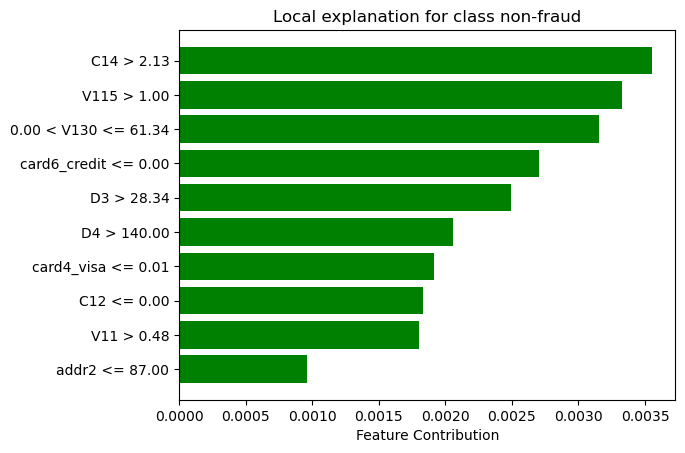

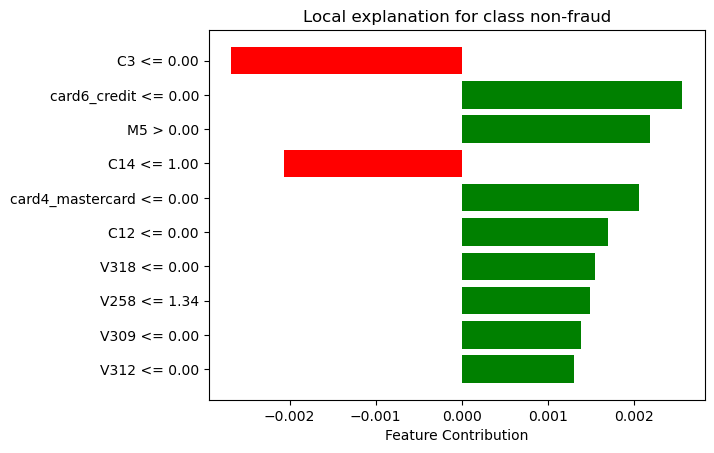

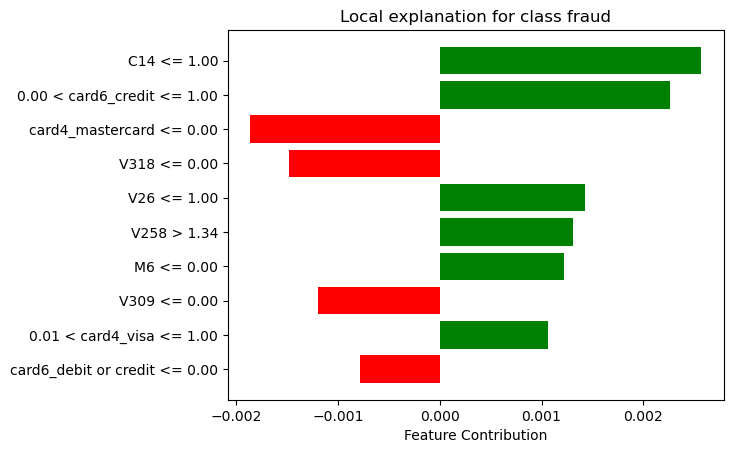

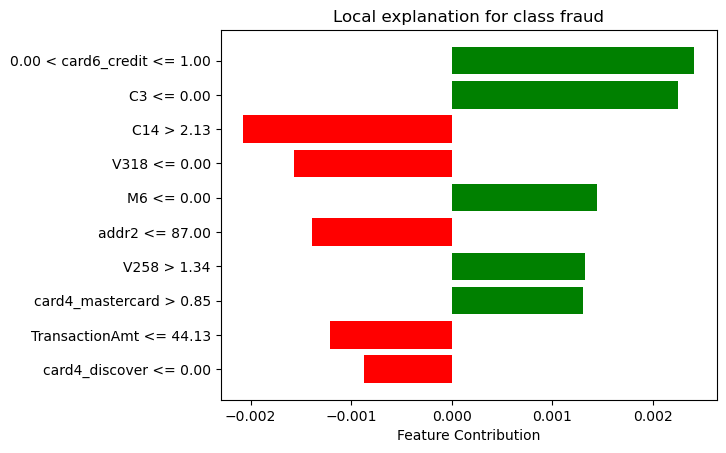

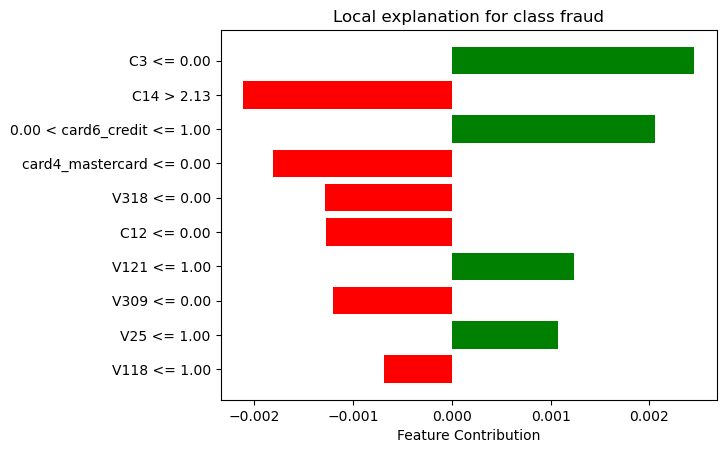

In [24]:
for exp in selected_explanations:
    predicted_class = list(exp.local_exp.keys())[0]
    fig = exp.as_pyplot_figure(label=predicted_class)
    # Label the x-axis
    plt.xlabel("Feature Contribution")
    plt.show()

#### 5.4.2 Applying NormLIME to the XGBoost Model
* This is a variant of LIME

In [25]:
from collections import Counter

In [26]:
start_time = time.time()

In [27]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_names,
    class_names=["non-fraud", "fraud"],
    mode='classification',
    verbose=True,
    random_state = 1
)

In [28]:
# Generate explanations for multiple instances. Suppress textual output
with suppress_stdout_stderr():
    explanations = []
    for i in range(100):  # Adjust the number of instances as needed
        explanation = lime_explainer.explain_instance(X_test.iloc[i].values, xgb.predict_proba)
        explanations.append(explanation)

In [29]:
# Aggregate feature importance
feature_importance = Counter()
for explanation in explanations:
    for feature, weight in explanation.as_list():
        feature_importance[feature] += weight

In [30]:
# Normalize the feature importance
total_importance = sum(feature_importance.values())
normalized_importance = {feature: weight / total_importance for feature, weight in feature_importance.items()}

In [31]:
end_time = time.time()
explanation_time = end_time - start_time
print(f"NormLIME on XGBoost (Explanation Time): {explanation_time:.2f} seconds")

NormLIME on XGBoost (Explanation Time): 135.06 seconds


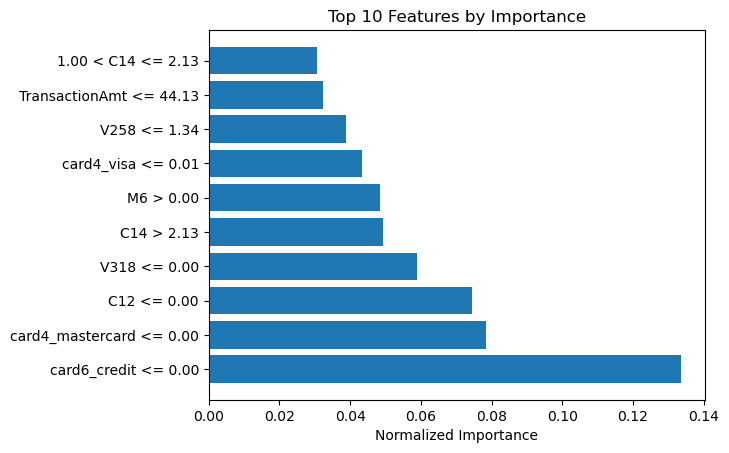

In [32]:
#Visualize the feature importance
# Sort features by importance
sorted_features = sorted(normalized_importance.items(), key=lambda x: x[1], reverse=True)

# Plot the top N features
top_n = 10
features, importances = zip(*sorted_features[:top_n])
plt.barh(features, importances)
plt.xlabel('Normalized Importance')
plt.title('Top {} Features by Importance'.format(top_n))
plt.show()

#### 5.4.3 Applying Permutation Importance to the XGBoost Model

In [33]:
from sklearn.inspection import permutation_importance

In [34]:
start_time = time.time()

In [35]:
# Compute permutation importance
result = permutation_importance(
    xgb, X_test, y_test,
    n_repeats=10, random_state=42, scoring='roc_auc'
)

In [36]:
end_time = time.time()
explanation_time = end_time - start_time
print(f"Permutation Important on XGBoost (Explanation Time): {explanation_time:.2f} seconds")

Permutation Important on XGBoost (Explanation Time): 365.72 seconds


In [37]:
# Store results in DataFrame
pi_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

In [38]:
print(pi_df.head(15))

            feature  importance_mean  importance_std
181            V318         0.017698        0.000556
193    card6_credit         0.017629        0.001112
5               C12         0.014200        0.000315
1    TransactionAmt         0.013133        0.000674
71              V70         0.013115        0.000853
7               C14         0.008587        0.000491
178            V312         0.008289        0.000777
160            V282         0.007958        0.000478
0     TransactionDT         0.006720        0.000495
175            V309         0.005621        0.000434
8             card2         0.005298        0.000420
194     card6_debit         0.004978        0.000413
13    P_emaildomain         0.004159        0.000265
16               M6         0.003974        0.000422
185     ProductCD_R         0.003751        0.000249


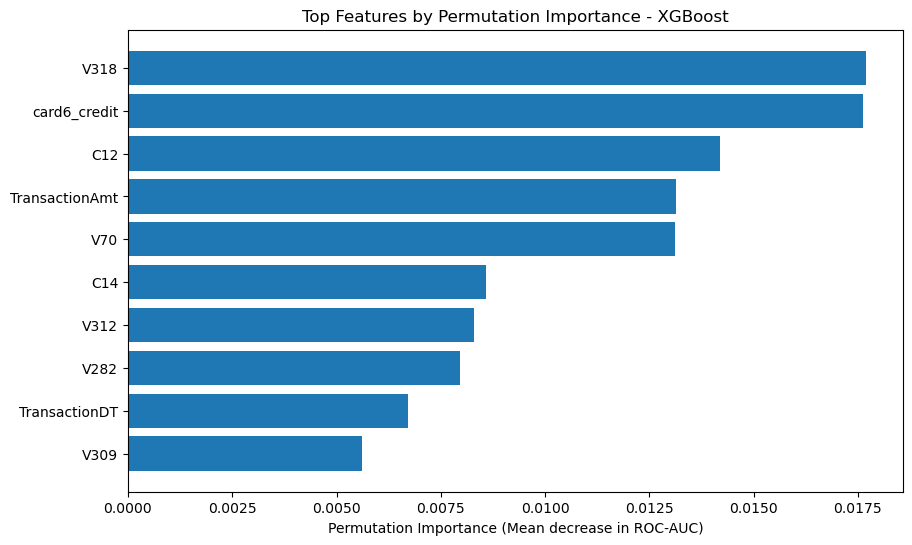

In [39]:
# Plot top 15 features
top_n = 10
plt.figure(figsize=(10,6))
plt.barh(pi_df['feature'].head(top_n)[::-1], pi_df['importance_mean'].head(top_n)[::-1])
plt.xlabel("Permutation Importance (Mean decrease in ROC-AUC)")
plt.title("Top Features by Permutation Importance - XGBoost")
plt.show()

#### 5.4.4 Applying Adversarial Explanations to the XGBoost Model

In [40]:
from scipy.optimize import differential_evolution

In [41]:
### Applying Feature Scaling since it is a distance based explanation
sc = StandardScaler()
X_tn_scaled = sc.fit_transform(X_train)
X_tt_scaled = sc.fit_transform(X_test)


# Convert to dataframe
X_train_scaled = pd.DataFrame(X_tn_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_tt_scaled, columns=X_test.columns)

In [42]:
# Define adversarial explanation function 
def adversarial_explanation(model,
    x_orig,                     # 1D numpy array (already preprocessed to model input space)
    target_label=None,          # desired target label (0 or 1). If None -> flip original label.
    feature_bounds=None,        # list of (min, max) for each feature (in same scaled space as x_orig)
    maxiter=200,                # DE iterations
    popsize=15,                 # DE population size multiplier
    penalty_coef=50.0,          # strength of constraint penalty
    norm='l2',                  # 'l2' or 'linf'
    random_state=0
):
    """
    Find a minimal perturbation delta such that model.predict_proba(x_orig + delta) yields target_label.
    Uses differential_evolution (global, gradient-free).
    Returns: dict { 'delta', 'x_adv', 'orig_prob', 'adv_prob', 'success', 'distance' }
    """
    rng = np.random.RandomState(random_state)
    x_orig = np.asarray(x_orig).astype(float).ravel()
    n = x_orig.size

    # current predicted label and probability
    prob_orig = model.predict_proba(x_orig.reshape(1, -1))[0,1]
    label_orig = int(prob_orig >= 0.5)
    if target_label is None:
        target = 1 - label_orig
    else:
        target = int(target_label)

    # bounds for delta: by default allow changes within (min_feature - val, max_feature - val)
    if feature_bounds is None:
        # set bounds from training feature ranges (we'll use training min/max scaled)
        # Compute safe bounds around x_orig: +/- 3 STD (in scaled space that's reasonable)
        # but to be general, allow range [-clip, +clip] where clip = max(abs(min,max)) * 1.1
        # Here we set per-feature bounds to ensure we stay inside plausible values.
        fb = []
        X_all = np.vstack([X_train_scaled.values, X_test_scaled.values])
        min_col = X_all[:, :].min(axis=0)
        max_col = X_all[:, :].max(axis=0)
        for i in range(n):
            # bounds for delta so that x_adv remains in [min_col[i], max_col[i]]
            lo = min_col[i] - x_orig[i]
            hi = max_col[i] - x_orig[i]
            fb.append((lo, hi))
    else:
        # feature_bounds given as list of (min,max) for each feature in input space
        fb = []
        for i, (mn, mx) in enumerate(feature_bounds):
            fb.append((mn - x_orig[i], mx - x_orig[i]))

    # objective: minimize norm(delta) + penalty * max(0, threshold - prob_target)
    def objective(delta_flat):
        delta = np.array(delta_flat)
        x_candidate = x_orig + delta
        # clip to bounds (avoid invalid values)
        # compute predicted probability of target class
        proba = model.predict_proba(x_candidate.reshape(1, -1))[0, 1]
        # fitness for target: we want proba_target >= 0.5 if target==1; else <=0.5
        if target == 1:
            violation = max(0.0, 0.5 - proba)
        else:
            violation = max(0.0, proba - 0.5)
        # distance measure
        if norm == 'l2':
            dist = np.linalg.norm(delta)
        elif norm == 'linf':
            dist = np.max(np.abs(delta))
        else:
            dist = np.linalg.norm(delta)
        # objective: distance + penalty * violation
        return dist + penalty_coef * violation

    # differential evolution
    result = differential_evolution(
        objective,
        fb,
        maxiter=maxiter,
        popsize=popsize,
        tol=1e-5,
        polish=True,
        updating='deferred',
        seed=random_state,
        mutation=(0.5, 1.0),
        recombination=0.7,
    )

    delta_opt = result.x
    x_adv = x_orig + delta_opt
    prob_adv = model.predict_proba(x_adv.reshape(1, -1))[0,1]
    success = (prob_adv >= 0.5 and target == 1) or (prob_adv < 0.5 and target == 0)
    distance = np.linalg.norm(delta_opt) if norm == 'l2' else np.max(np.abs(delta_opt))

    return {
        'delta': delta_opt,
        'x_adv': x_adv,
        'orig_prob': prob_orig,
        'adv_prob': prob_adv,
        'success': success,
        'distance': distance,
        'result_obj': result
    }

In [43]:
start_time = time.time()

In [44]:
# Run adversarial explanation for one test instance
idx = 0
x0 = X_test_scaled.iloc[idx].values  # already scaled to model input
ae = adversarial_explanation(xgb, x0, target_label=None, maxiter=100, popsize=10, penalty_coef=200.0, norm='l2', random_state=0)

In [45]:
end_time = time.time()
explanation_time = end_time - start_time
print(f"Adversarial Expanations on XGBoost (Explanation Time): {explanation_time:.2f} seconds")

Adversarial Expanations on XGBoost (Explanation Time): 189.05 seconds


In [46]:
print("Original prob (class=1):", ae['orig_prob'])
print("Adversarial prob (class=1):", ae['adv_prob'])
print("Success flipped?:", ae['success'])
print("L2 distance of delta:", ae['distance'])

Original prob (class=1): 0.63341856
Adversarial prob (class=1): 0.10523546
Success flipped?: True
L2 distance of delta: 266.73174768076706


In [47]:
# show top changed features
delta = ae['delta']
df_changes = pd.DataFrame({
    'feature': X_test_scaled.columns,
    'orig': x0,
    'adv': ae['x_adv'],
    'delta': delta,
    'abs_delta': np.abs(delta)
}).sort_values('abs_delta', ascending=False)

print("\nTop feature changes (by absolute perturbation):")
print(df_changes.head(10).to_string(index=False))


Top feature changes (by absolute perturbation):
              feature      orig       adv     delta  abs_delta
                  V56 -0.179712 61.378645 61.558357  61.558357
                 V110 -0.079731 53.956613 54.036344  54.036344
                 V131  0.359878 51.504795 51.144916  51.144916
card6_debit or credit -0.005820 50.428938 50.434758  50.434758
                 V244  0.002224 48.721980 48.719756  48.719756
                 V228  0.001315 48.400838 48.399523  48.399523
                 V262 -0.004221 46.808101 46.812323  46.812323
                 V311 -0.083457 43.105567 43.189024  43.189024
                 V290 -0.133411 42.525499 42.658910  42.658910
                 V309 -0.136670 41.276227 41.412897  41.412897


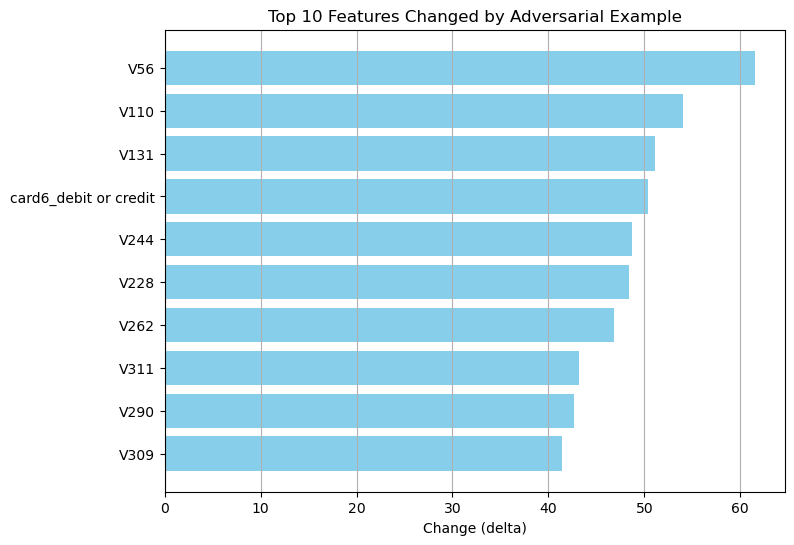

In [48]:
# Take top 10 features by absolute change
top_changes = df_changes.head(10).sort_values('abs_delta', ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(top_changes['feature'], top_changes['delta'], color='skyblue')
plt.xlabel('Change (delta)')
plt.title('Top 10 Features Changed by Adversarial Example')
plt.grid(axis='x')
plt.show()